# Detecting gradients with suave: Single-component basis

In [1]:
import numpy as np
import scipy
from scipy.interpolate import BSpline
from scipy.interpolate import _bspl
from colossus.cosmology import cosmology

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 150
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'medium',
         'axes.titlesize': 'medium',
         'xtick.labelsize': 'medium',
         'ytick.labelsize': 'medium',
         'figure.autolayout': True,
         'figure.figsize': (4,3),
         'text.usetex': True,
         'text.latex.preamble': [r"\usepackage{bm}"]}
pylab.rcParams.update(params)

%load_ext autoreload
%autoreload 2

In [2]:
import Corrfunc
from Corrfunc.io import read_lognormal_catalog
from Corrfunc.theory.DDsmu import DDsmu
from Corrfunc.utils import compute_amps
from Corrfunc.utils import evaluate_xi
from Corrfunc.utils import convert_3d_counts_to_cf

Load a catalog:

In [3]:
L = 750.0
x, y, z = read_lognormal_catalog('1e-4')
nd = len(x)
print("Number of data points:",nd)

Number of data points: 42876


Generate a random catalog:

In [4]:
randmult = 2
nr = nd*randmult
xr = np.random.rand(nr)*float(L)
yr = np.random.rand(nr)*float(L)
zr = np.random.rand(nr)*float(L)
print("Number of data points:", nr)

Number of data points: 85752


In [5]:
def cosmo_bases(rmin, rmax, projfn, cosmo_base=None, ncont=2000, 
              redshift=0.0, bias=1.0):
    '''
    Compute the 5-component BAO basis functions based on a cosmological model and 
    linearized around the scale dilation parameter alpha.

    Parameters
    ----------
    rmin : double
        Minimum r-value for basis functions

    rmax : double
        Maximum r-value for basis functions 

    projfn : string, default=None
        Path to projection file if necessary

    cosmo_base : nbodykit cosmology object, default=nbodykit.cosmology.Planck15
        Cosmology object for the BAO model.

    ncont : int, default=2000
        Number of continuous r-values at which to write the basis function file

    redshift : double, default=0.0
        Redshift at which to compute power spectrum

    alpha_guess : double, default=1.0
        The alpha (scale dilation parameter) at which to compute the model (alpha=1.0 is no scale shift)

    dalpha : double, default=0.001
        The change in alpha (scale dilation parameter) used to calculate the numerical partial derivative
    
    bias : double, default=1.0
        The bias parameter by which to scale the model amplitude (bias=1.0 indicates no bias)

    Returns
    -------
    bases: array-like, double
        2-d array of basis function values; first column is r-values

    '''
    if cosmo_base is None:
        print("cosmo_base not provided, defaulting to Planck 2015 cosmology ('planck15')")
        cosmo_base = cosmology.setCosmology('planck15')

    cf = cosmo_base.correlationFunction

    def cf_model(r):
        return bias * cf(r, z=redshift)

    rcont = np.linspace(rmin, rmax, ncont)
    bs = cf_model(rcont)

    nbases = 1
    bases = np.empty((ncont, nbases+1))
    bases[:,0] = rcont
    bases[:,1] = np.array(bs)

    np.savetxt(projfn, bases)
    ncomponents = bases.shape[1]-1
    return bases

Set the parameters for suave:

In [6]:
rmin = 40.0
rmax = 140.0
ntopbins = 10
#r_edges is a dummy for now, don't need for gradient
#but let's pass it something sensible for regular binned corrfunc for comparison
r_edges = np.linspace(rmin, rmax, ntopbins+1) 
ncont = 2000
r_fine = np.linspace(rmin, rmax, ncont)

nmubins = 1
mumax = 1.0
periodic = False #assume non-periodic for gradient finding!
nthreads = 2

proj_type = 'gradient'
weight_type = 'pair_product_gradient' #must set these waits
projfn = 'cosmo_basis.dat'

In [7]:
bases = cosmo_bases(rmin, rmax, projfn)
ncomponents = 4*(bases.shape[1]-1) #minus 1 bc r column included
r = bases[:,0]
base_vals = bases[:,1]

cosmo_base not provided, defaulting to Planck 2015 cosmology ('planck15')


No handles with labels found to put in legend.


Text(0, 0.5, '$\\xi(r)$')

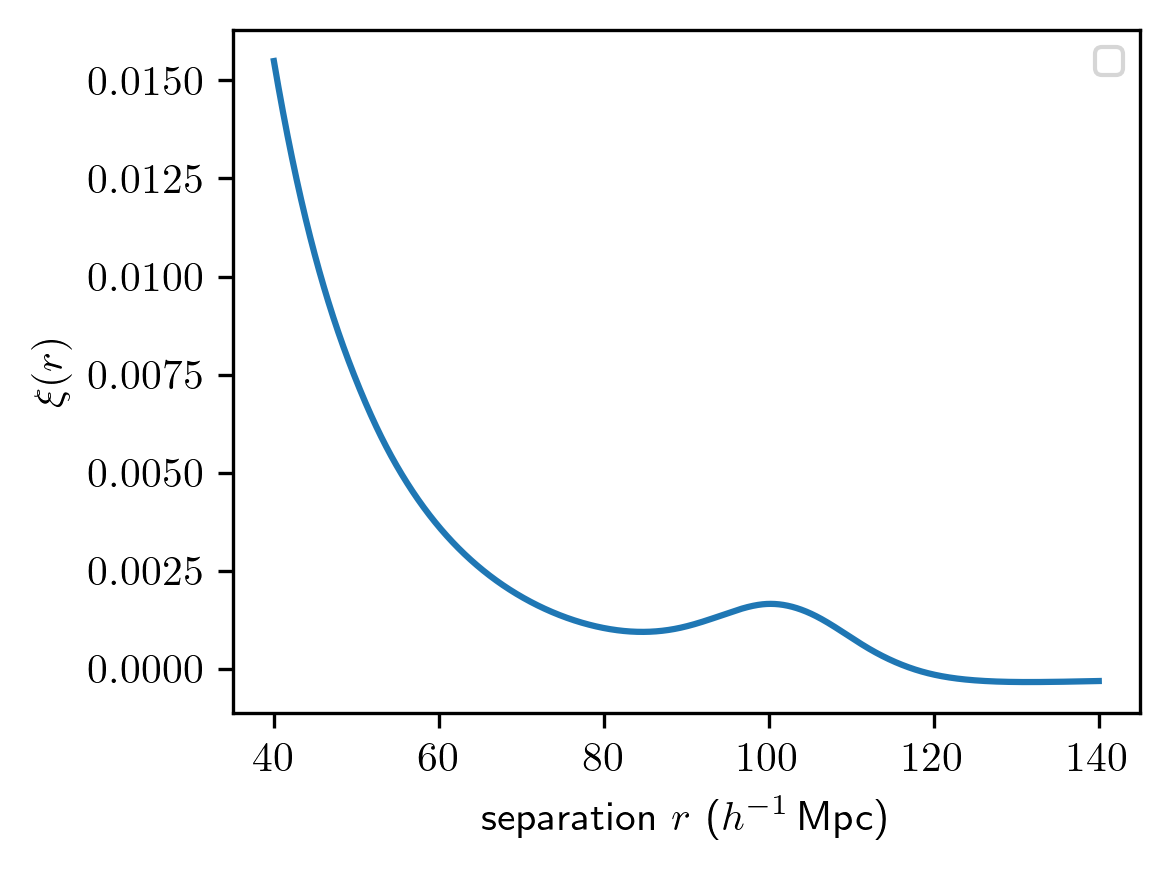

In [8]:
plt.figure(figsize=(4,3))
ax = plt.gca()
ax.plot(r, base_vals)
ax.legend()
ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
ax.set_ylabel(r'$\xi(r)$')

We need weights for the gradient function. The code expects an array of shape (n_weights, n_data). The first weight is the general weight for the galaxy, e.g. for systematics correction; for now we take it to be 1 for all galaxies, as these are theory boxes. The second weight is the x position of the galaxies, and the third and fourth the y and z positions respectively. 

In [9]:
loc_pivot = [L/2., L/2., L/2.]
weights = np.array([np.ones(len(x)), x-loc_pivot[0], y-loc_pivot[1], z-loc_pivot[2]])
weights_r = np.array([np.ones(len(xr)), xr-loc_pivot[0], yr-loc_pivot[1], zr-loc_pivot[2]])

Now we can run the pair counts! Make sure to pass the weights, the projection type, and the other parameters we set above.

In [ ]:
dd_res, dd_proj, _ = DDsmu(1, nthreads, r_edges, mumax, nmubins, x, y, z, weights1=weights, 
                           proj_type=proj_type, ncomponents=ncomponents, projfn=projfn, 
                           periodic=periodic, weight_type=weight_type)
print("DD:", np.array(dd_proj))

dr_res, dr_proj, _ = DDsmu(0, nthreads, r_edges, mumax, nmubins, x, y, z, weights1=weights, 
                           X2=xr, Y2=yr, Z2=zr, weights2=weights_r, 
                           proj_type=proj_type, ncomponents=ncomponents, projfn=projfn, 
                           periodic=periodic, weight_type=weight_type)
print("DR:", np.array(dr_proj))

rr_res, rr_proj, qq_proj = DDsmu(1, nthreads, r_edges, mumax, nmubins, xr, yr, zr, weights1=weights_r, 
                                 proj_type=proj_type, ncomponents=ncomponents, projfn=projfn, 
                                 periodic=periodic, weight_type=weight_type)
print("RR:", np.array(rr_proj))

DD: [ 40084.10360718 114600.68621062 -21710.12924006 193681.03128212]


In [ ]:
amps = compute_amps(ncomponents, nd, nd, nr, nr, dd_proj, dr_proj, dr_proj, rr_proj, qq_proj)
xi_proj = evaluate_xi(amps, r_fine, proj_type, rbins=r_edges, projfn=projfn)

Let's extract the standard binned values:

In [ ]:
dd = np.array([x['npairs'] for x in dd_res], dtype=float)
dr = np.array([x['npairs'] for x in dr_res], dtype=float)
rr = np.array([x['npairs'] for x in rr_res], dtype=float)
xi_standard = convert_3d_counts_to_cf(nd, nd, nr, nr, dd, dr, dr, rr)
r_avg = 0.5*(r_edges[:-1] + r_edges[1:])

Here is our estimated correlation function:

In [ ]:
plt.figure(figsize=(4,3))
ax = plt.gca()
ax.plot(r_avg, xi_standard, ls='None', marker='o', color='grey', markersize=3, label='Standard binned')
ax.plot(r_fine, xi_proj, label='Cosmo basis with gradient')
ax.legend()
ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
ax.set_ylabel(r'$\xi(r)$')

Let's check the recovered gradient!

In [ ]:
print("amps = ", amps)
w_cont = amps[1:]/amps[0]
w_cont_norm = np.linalg.norm(w_cont)
w_cont_hat = w_cont/w_cont_norm
print("w_cont = ", w_cont)
print(f"||w_cont|| = {w_cont_norm:.6f}")
b_guess = 0.5
m_recovered_perL = w_cont_norm*b_guess*L
print(f"If we assume an initial b={b_guess}, this gives m = {m_recovered_perL:.4f}/L")

Cool, let's plot the correlation functions along the gradient axis:

In [ ]:
fig = plt.figure()
ax = plt.gca()

v_min = -L/2.
v_max = L/2.
vs_norm = matplotlib.colors.Normalize(vmin=v_min, vmax=v_max)
cmap = matplotlib.cm.get_cmap('cool')
nvs = 10
vs = np.linspace(v_min, v_max, nvs)

for i, v in enumerate(vs):
    
    loc = loc_pivot + v*w_cont_hat
    if i==len(vs)-1:
        print(loc)
    weights1 = np.array(np.concatenate(([1.0], loc-loc_pivot)))
    weights2 = weights1 #because we just take the average of these and want to get this back
    
    xi_loc = evaluate_xi(amps, r_fine, proj_type, projfn=projfn, 
                     weights1=weights1, weights2=weights2, weight_type=weight_type)    
    
    p = plt.plot(r_fine, xi_loc, color=cmap(vs_norm(v)), lw=0.5)
    
    
sm = plt.cm.ScalarMappable(cmap=cmap, norm=vs_norm)
cbar = plt.colorbar(sm)
cbar.set_label(r'$v \,\, (\mathbf{x} = v\hat{e}_\mathrm{gradient} + \mathbf{x}_\mathrm{pivot})$', rotation=270, labelpad=12)
ax.axhline(0, color='grey', lw=0.5)
ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
ax.set_ylabel(r'$\xi(r)$')

We can clearly see the gradient!